<a href="https://colab.research.google.com/github/michaelsong4399/asteroseismology/blob/yihong/NNFourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightkurve
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install tensorflow
!pip install astropy

     |████████████████████████████████| 235kB 5.8MB/s 
     |████████████████████████████████| 256kB 20.4MB/s 
     |████████████████████████████████| 22.2MB 65.0MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 788kB 42.4MB/s 
     |████████████████████████████████| 6.5MB 19.1MB/s 
     |████████████████████████████████| 368kB 47.7MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 3.2MB 25.2MB/s 
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=76c35a43ff0a1589c8892e4907d43c71e88f70917380a95347832f591f41c113
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11377 sha256=8e4f0c9c597a7692fb395c90c250a0068491f665250a0a2e71f1f8ad6f75d683
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3

In [ ]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import scipy
import pandas as pd 
from scipy import interpolate
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5
        

# Surface Velocity

In [ ]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [ ]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

In [ ]:
def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

In [ ]:
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


# Sunspot Number

In [ ]:
#sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
sunspot_Day = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

#sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [ ]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

In [ ]:
def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

In [ ]:
getSN_Day(cycle_23)

array([[2.4502965e+06, 2.6000000e+01],
       [2.4502975e+06, 3.1000000e+01],
       [2.4502985e+06, 3.1000000e+01],
       ...,
       [2.4547985e+06, 0.0000000e+00],
       [2.4547995e+06, 0.0000000e+00],
       [2.4548005e+06, 0.0000000e+00]])

In [ ]:
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

# Preprocessing


In [ ]:
def getPeriodogram(time,freq):
    lc = lk.LightCurve(time=time.tolist(),flux=freq.tolist())
    lc = lc.remove_nans()
    pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=1000, maximum_frequency=5000)
    #ax = pg.plot()
    pg_data = pg.to_table()
    data = np.array(pg_data['power']).T.tolist()


    # pg.smooth(method='boxkernel', filter_width=1.)#.plot(ax=ax, label='Smoothed', c='red', lw=2)
    # #ax.axvline(pg.frequency_at_max_power.value, lw=2, ls='dashed')
    # snr = pg.flatten()
    # seis = snr.to_seismology()
    # numax = seis.estimate_numax()
    # numax = float(str(numax)[0:7])
    return data

In [ ]:
pg = getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000])

In [ ]:
print(pg[0:5])

[9.43163103153356e-06, 9.016830090272811e-06, 9.536233388341783e-05, 4.532975548160552e-05, 6.06767015124889e-05]


In [ ]:
def tsNumax(time,freq,length,interval):
    length = int(length * 2160)
    interval = int(interval * 2160)
    
    npout = [[0,0]]
    for start in range(0,len(time),interval):
        if start + length >= len(time):
            length = len(time) - start
        npout = np.append(npout,[[time[start],getPeriodogram(time[start:start+length],freq[start:start+length])]],0)
    npout = npout[1:]
    return npout

In [ ]:
numax_cycle_23_182 = tsNumax(getSV_index(cycle_23),getSV(cycle_23),182.5,91.25)
#print(numax_cycle_23)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
print(numax_cycle_23_182[0:3])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# SN

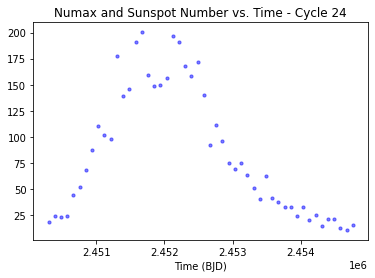

100


In [ ]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),91.25)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]

plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(datax_SN,datay_SN, s = 10, c='blue', alpha=0.5)
plt.show()
print(data_SN.size)


In [ ]:
train_x = numax_cycle_23_182.T[1]
train_y_pre = datay_SN
print(train_x.shape, train_y_pre.shape)
#train_x = np.reshape(train_x, (-1, 2160))
print(train_x.shape)
print(max(train_y_pre))
print(train_x)

# normalize
train_y = np.divide(train_y_pre,353.0)
print(max(train_y),train_y.shape)

(50,) (50,)
(50,)
200.26373626373626


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
tf.test.gpu_device_name()
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()

model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))
model.add(layers.Dense(512, activation='relu', input_shape=(train_x.shape)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               26112     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 34,337
Trainable params: 34,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, epochs=100,
                   validation_data=(train_x, train_y))

ValueError: ignored